# Project - Product Recommendation Systems

### Submitted by - Abhik Kar 
#### Dated - 29-Jun-2020

#### Domain - E-commerce
* Products are being recommended to users based on popularity and other metrics on e-commerce websites. 
* Majority of the E-commerce website are using product recommendations to boosts their revenues 

##### Problem Statement
* To build a recommendation system that recommends at least five(5) new products based on the user's habits

##### Solution
* Apply EDA
* Data Wrangling
* Build a Popularity recommender model
* Build Collaborative Filtering model

In [1]:
import os
import numpy as np  
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.linalg import svds
import joblib
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Read the csv file into a dataframe
ratings_data = pd.read_csv("ratings_Electronics.csv")  
ratings_data.head() 

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [3]:
ratings_data.columns = ['userId','productId', 'ratings', 'timestamp']

In [4]:
ratings_data.head()

,userId,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
# Check the number of rows and columns
rows, columns = ratings_data.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824481
No of columns:  4


In [6]:
#Check Data types
ratings_data.dtypes

userId        object
productId     object
ratings      float64
timestamp      int64
dtype: object

### Missing Value Analysis

In [7]:
ratings_data.isnull().values.any()

False

In [8]:
# Check for missing values present
print('Number of missing values across columns-\n', ratings_data.isnull().sum())

Number of missing values across columns-
 userId       0
productId    0
ratings      0
timestamp    0
dtype: int64


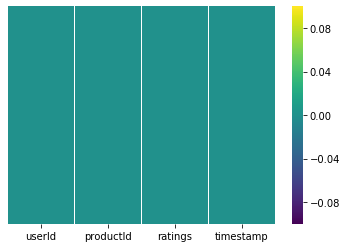

In [9]:
sns.heatmap(ratings_data.isnull(), yticklabels=False, cmap="viridis")

#### There are no missing values in total records 7824481

In [10]:
# Summary statistics of 'rating' variable
ratings_data['ratings'].describe().T

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [11]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(ratings_data['ratings'].min()))
print('The maximum rating is: %d' %(ratings_data['ratings'].max()))

The minimum rating is: 1
The maximum rating is: 5


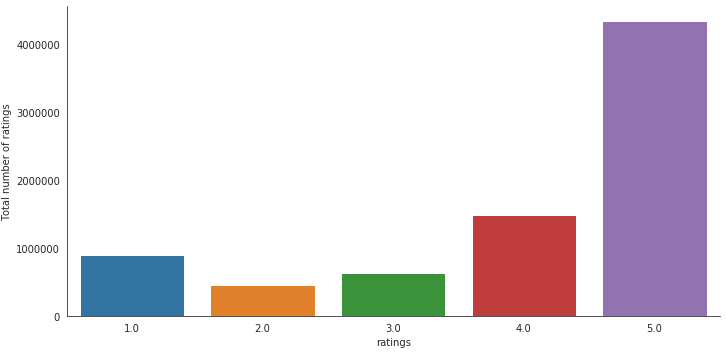

In [12]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    dist = sns.factorplot("ratings", data=ratings_data, aspect=2.0,kind='count')
    dist.set_ylabels("Total number of ratings") 

In [13]:
ratings_data['timestamp'] = pd.to_datetime(ratings_data['timestamp'], unit = 's')
ratings_data['Year'] = ratings_data['timestamp'].dt.year

Trend of ratings over the years
--------------------------------------------------------------------------------


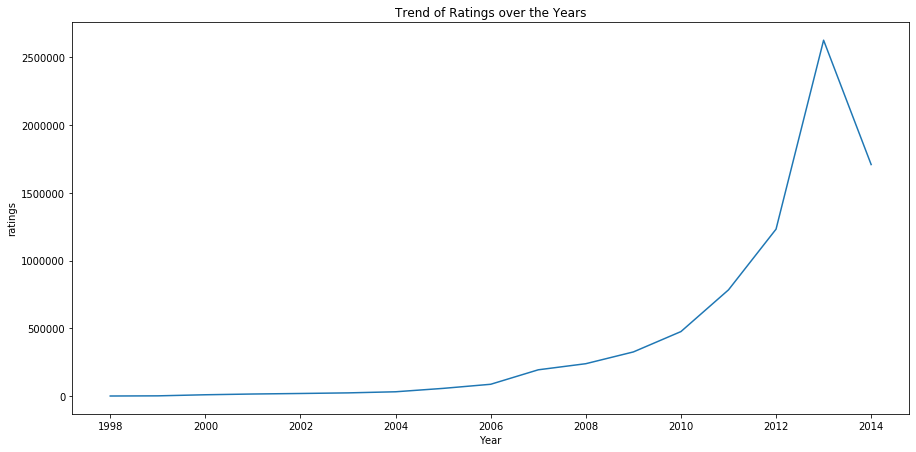

In [14]:
print('Trend of ratings over the years'); print('--'*40)
ratings_over_years = ratings_data.groupby(by = 'Year', as_index = False)['ratings'].count()

fig = plt.figure(figsize = (15, 7.2))
g = sns.lineplot(x = 'Year', y = 'ratings', data = ratings_over_years).set_title('Trend of Ratings over the Years')

del g, ratings_over_years

In [15]:
# Number of unique user id and product id in the data
print('Number of unique Users in Raw data = ', ratings_data['userId'].nunique())
print('Number of unique Products in Raw data = ', ratings_data['productId'].nunique())

Number of unique Users in Raw data =  4201696
Number of unique Products in Raw data =  476001


#### Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings)

In [16]:
# Top 10 users based on rating
ratings_data.groupby('userId')['ratings'].count().sort_values(ascending=False).head(10)

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
Name: ratings, dtype: int64

### Prepare Data model with users who have rated 50 or more products

In [17]:
counts = ratings_data['userId'].value_counts()
ratings_top50 = ratings_data[ratings_data['userId'].isin(counts[counts >=50].index)]

In [18]:
# Top 10 users based on rating
ratings_top50.groupby('userId')['ratings'].count().sort_values(ascending=False).head(10)

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
Name: ratings, dtype: int64

In [19]:
print('Number of users who have rated 50 or more items =', len(ratings_top50))
print(round((len(ratings_top50)/len(ratings_data))*100,2),'% Out of total holds the users who have rated 50 or more products')
print('Number of unique Users in final data = ', ratings_top50['userId'].nunique())
print('Number of unique Products in final data = ', ratings_top50['productId'].nunique())

Number of users who have rated 50 or more items = 125871
1.61 % Out of total holds the users who have rated 50 or more products
Number of unique Users in final data =  1540
Number of unique Products in final data =  48190


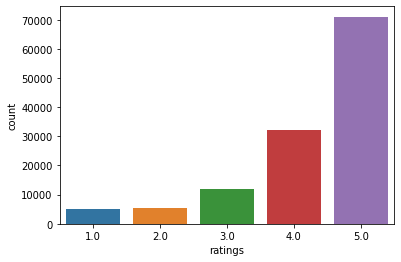

In [20]:
sns.countplot(data=ratings_top50 , x='ratings')
plt.show()

Observation:
* The users who have rated 50 or more products have rated more with higher rating and less with lower ratings

In [21]:
# Summary statistics of 'rating' variable for the users who have rated 50 or more items
ratings_top50['ratings'].describe().T

count    125871.000000
mean          4.261339
std           1.062144
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: ratings, dtype: float64

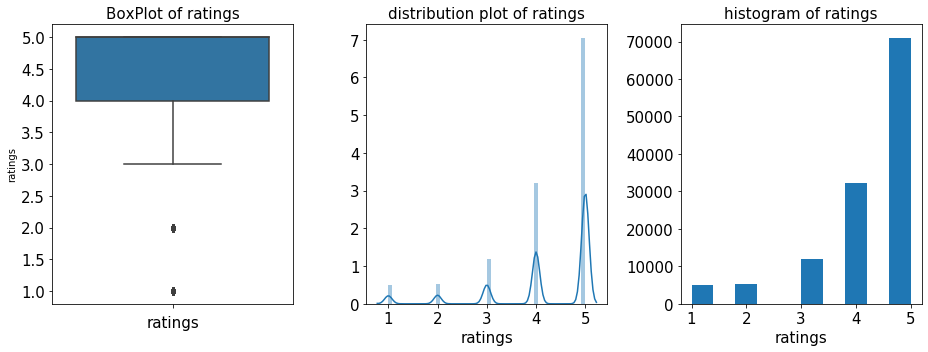

In [22]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(13,5))

#boxplot
sns.boxplot(x='ratings',data=ratings_top50,orient='v',ax=ax1)
ax1.set_xlabel('ratings', fontsize=15)
ax1.set_title('BoxPlot of ratings', fontsize=15)
ax1.tick_params(labelsize=15)

#distplot
sns.distplot(ratings_top50['ratings'],ax=ax2)
ax2.set_xlabel('ratings', fontsize=15)
ax2.set_title('distribution plot of ratings', fontsize=15)
ax2.tick_params(labelsize=15)

#histogram
ax3.hist(ratings_top50['ratings'])
ax3.set_xlabel('ratings', fontsize=15)
ax3.set_title('histogram of ratings', fontsize=15)
ax3.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

Observation:
* The users who have rated 50 or more products have rated more with higher rating and less with lower ratings
* The ratings where users rated lower are appearing as outlier

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D86488E08>,
      dtype=object)

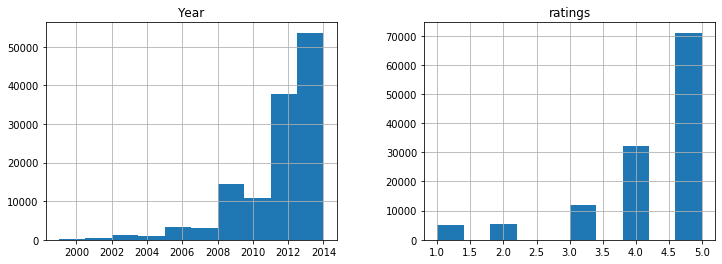

In [23]:
ratings_top50.hist(figsize=(12,4))

Observation:
*Over a period of time the ratings of the products improved

In [24]:
ratings_top50.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()

productId
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: ratings, dtype: float64

#### Droping the timestamp column as in this case for builing recommendation system it's of no use

In [25]:
ratings_top50 = ratings_top50.drop(['timestamp'], axis=1)
ratings_top50.head()

,userId,productId,ratings,Year
93,A3BY5KCNQZXV5U,0594451647,5.0,2014
117,AT09WGFUM934H,0594481813,3.0,2013
176,A32HSNCNPRUMTR,0970407998,1.0,2011
177,A17HMM1M7T9PJ1,0970407998,4.0,2010
491,A3CLWR1UUZT6TG,0972683275,5.0,2013


#### Calculate the density of the rating matrix

In [26]:
final_ratings_matrix = ratings_top50.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [27]:
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split the data randomly into a train and test dataset in 70:30 ratio

In [29]:
#Split the data randomly into training and test data in the ratio 70:30
train_data, test_data = train_test_split(ratings_top50, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings,Year
6595852,A2BYV7S1QP2YIG,B009EAHVTA,5.0,2014
4738240,AB094YABX21WQ,B0056XCEAA,1.0,2011
4175595,A3D0UM4ZD2CMAW,B004I763AW,5.0,2012
3753015,AATWFX0ZZSE6C,B0040NPHMO,3.0,2010
1734766,A1NNMOD9H36Q8E,B0015VW3BM,4.0,2008


In [30]:
print(train_data.shape)
print(test_data.shape)

(88109, 4)
(37762, 4)


## Build Popularity Recommender model

In [31]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)

In [32]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [33]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [34]:
find_recom = [6595852,4738240,3753015]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId:",train_data.userId[i],"\n")
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A2BYV7S1QP2YIG 

        userId   productId  score  Rank
30847  6595852  B0088CJT4U    133   1.0
30287  6595852  B007WTAJTO    124   2.0
19647  6595852  B003ES5ZUU    122   3.0
8752   6595852  B000N99BBC    114   4.0
30555  6595852  B00829THK0     97   5.0


Here is the recommendation for the userId: AB094YABX21WQ 

        userId   productId  score  Rank
30847  4738240  B0088CJT4U    133   1.0
30287  4738240  B007WTAJTO    124   2.0
19647  4738240  B003ES5ZUU    122   3.0
8752   4738240  B000N99BBC    114   4.0
30555  4738240  B00829THK0     97   5.0


Here is the recommendation for the userId: AATWFX0ZZSE6C 

        userId   productId  score  Rank
30847  3753015  B0088CJT4U    133   1.0
30287  3753015  B007WTAJTO    124   2.0
19647  3753015  B003ES5ZUU    122   3.0
8752   3753015  B000N99BBC    114   4.0
30555  3753015  B00829THK0     97   5.0




## Build Collaborative Filtering model

In [35]:
# Model-based Collaborative Filtering: Singular Value Decomposition
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userId,productId,ratings,Year
0,6595852,A2BYV7S1QP2YIG,B009EAHVTA,5.0,2014
1,4738240,AB094YABX21WQ,B0056XCEAA,1.0,2011
2,4175595,A3D0UM4ZD2CMAW,B004I763AW,5.0,2012
3,3753015,AATWFX0ZZSE6C,B0040NPHMO,3.0,2010
4,1734766,A1NNMOD9H36Q8E,B0015VW3BM,4.0,2008


In [36]:
print(df_CF.shape)

(125871, 5)


In [37]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.shape

(1540, 48190)

In [38]:
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [40]:
print("User ID = A2BYV7S1QP2YIG  hold an index value of ",pivot_df.user_index['A2BYV7S1QP2YIG'])
print("User ID = AB094YABX21WQ   hold an index value of ",pivot_df.user_index['AB094YABX21WQ'])
print("User ID = AATWFX0ZZSE6C   hold an index value of ",pivot_df.user_index['AATWFX0ZZSE6C'])

User ID = A2BYV7S1QP2YIG  hold an index value of  530
User ID = AB094YABX21WQ   hold an index value of  1256
User ID = AATWFX0ZZSE6C   hold an index value of  1253


* User Index will be used to compare the recommendation for the same user in popularity based vs collaborative filtering 

In [41]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD (Singular Value Decomposition) method

In [42]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [43]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [44]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [45]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 530
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 530):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.948009
B003ES5ZUU                  0.0          0.549885
B005HMKKH4                  0.0          0.388070
B001TH7GUU                  0.0          0.381928
B002WE6D44                  0.0          0.381670


##### Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [46]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [48]:
# Predicted ratings 
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [49]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [50]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [51]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



In [52]:
#Store the accuracy results of each model in a dataframe for final comparison
Accuracy_Matrix = pd.DataFrame({'Collaborative Filtering':['SVD Model'], 'RMSE': format(RMSE) },index={'1'})
Accuracy_Matrix = Accuracy_Matrix[['Collaborative Filtering', 'RMSE']]
Accuracy_Matrix

,Collaborative Filtering,RMSE
1,SVD Model,0.0033


#### Top Five ( K = 5) recommendations for a user

In [53]:
# Enter 'userID' and 'num_recommendations' for the user #530
userID = 530
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 530):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.948009
B003ES5ZUU                  0.0          0.549885
B005HMKKH4                  0.0          0.388070
B001TH7GUU                  0.0          0.381928
B002WE6D44                  0.0          0.381670


## Collaborative Filtering Using Surprise Library

In [54]:
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor

reader = Reader(rating_scale=(1, 10))

In [55]:
ratings_top50.head()

,userId,productId,ratings,Year
93,A3BY5KCNQZXV5U,0594451647,5.0,2014
117,AT09WGFUM934H,0594481813,3.0,2013
176,A32HSNCNPRUMTR,0970407998,1.0,2011
177,A17HMM1M7T9PJ1,0970407998,4.0,2010
491,A3CLWR1UUZT6TG,0972683275,5.0,2013


In [56]:
ratings_top50.shape

(125871, 4)

### Using Surprise Library SVD Based Recommendation System

In [57]:
from surprise import Dataset,Reader

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_top50[['userId', 'productId', 'ratings']], reader)

In [58]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.3,random_state=1)

In [59]:
trainset.all_ratings()

<generator object Trainset.all_ratings at 0x0000015D8E429948>

In [60]:
from surprise import SVD, KNNWithMeans
from surprise import accuracy

In [61]:
svd_model = SVD(n_factors=5,biased=False)
svd_model.fit(trainset)

In [62]:
testset[0]

('A3PDWA32BAMB2Y', 'B00CGW74YU', 5.0)

In [63]:
test_pred = svd_model.test(testset)

In [64]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.6993


1.6993275194652637

In [65]:
#Store the accuracy results of each model in a dataframe for final comparison
Accuracy_Matrix_surprise_SVD = pd.DataFrame({'Collaborative Filtering':['SVD Model (Surprise Library)'], 'RMSE': accuracy.rmse(test_pred) },index={'2'})
Accuracy_Matrix = pd.concat([Accuracy_Matrix, Accuracy_Matrix_surprise_SVD])
Accuracy_Matrix

RMSE: 1.6993


,Collaborative Filtering,RMSE
1,SVD Model,0.0033
2,SVD Model (Surprise Library),1.69933


### KNNWithMeans

In [67]:
from surprise import KNNWithMeans
from surprise import accuracy

algo_i = KNNWithMeans(k=10, sim_options={ 'user_based': False})

algo_i.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [68]:
test_pred=algo_i.test(testset)

In [69]:
uid = str('A2BYV7S1QP2YIG')  # raw user id
iid = "B00000J1SC"  # raw item id

# get a prediction for specific users and items
pred = algo_i.predict(uid, iid, r_ui=0.0, verbose=True)

user: A2BYV7S1QP2YIG item: B00000J1SC r_ui = 0.00   est = 4.57   {'actual_k': 10, 'was_impossible': False}


In [70]:
pred = pd.DataFrame(test_pred)
pred[pred['uid'] == 'A2BYV7S1QP2YIG'][['iid', 'r_ui','est']].sort_values(by = 'est',ascending = False).head(5)

,iid,r_ui,est
31164,B005MWMBBM,5.0,5.314000
19927,B00KWMNDDM,5.0,5.198095
6366,B00G335A58,5.0,5.114016
1955,B00H3OYSHW,5.0,5.114016
11052,B00BF37SKG,5.0,5.090539


In [71]:
print(accuracy.rmse(test_pred))

RMSE: 1.1428
1.142754863966992


In [72]:
#Store the accuracy results of each model in a dataframe for final comparison
Accuracy_Matrix_surprise_KNN = pd.DataFrame({'Collaborative Filtering':['KNN With Means'], 'RMSE': accuracy.rmse(test_pred) },index={'3'})
Accuracy_Matrix = pd.concat([Accuracy_Matrix, Accuracy_Matrix_surprise_KNN])
Accuracy_Matrix

RMSE: 1.1428


,Collaborative Filtering,RMSE
1,SVD Model,0.0033
2,SVD Model (Surprise Library),1.69933
3,KNN With Means,1.14275


## SVD Model is the best recommendation model in this case

### Top Five ( K = 5) recommendations to each user of new products based on the user's habits
* Use SVD Model as the RMSE is lowest and turnsout to be the best suitable model for recommending Top 5 Products
* Recommend  5 new products to each user based on the user habits

In [73]:
# Enter 'userID' and 'num_recommendations' for the user #530
userID = 530
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 530):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.948009
B003ES5ZUU                  0.0          0.549885
B005HMKKH4                  0.0          0.388070
B001TH7GUU                  0.0          0.381928
B002WE6D44                  0.0          0.381670


In [74]:
# Enter 'userID' and 'num_recommendations' for the user #1256
userID = 1256
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1256):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          1.033738
B002V88HFE                  0.0          0.590877
B001TH7GUU                  0.0          0.571233
B002WE6D44                  0.0          0.485163
B000QUUFRW                  0.0          0.483533


In [75]:
# Enter 'userID' and 'num_recommendations' for the user #1253
userID = 1253
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1253):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.234042
B003ES5ZUU                  0.0          0.232475
B00829TIEK                  0.0          0.231165
B002R5AM7C                  0.0          0.220619
B005HMKKH4                  0.0          0.201024


## Conclusion

* Irrespective of Users Popularity based recommendation model provides the top rated products. 
* The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.
* The Popularity-based recommender system will not be considered for recommendation in this case as we have data on User's preference and can be leveraged through collaborative filtering method.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user.

* The Popularity based model has recommended the same set of 5 products to all the users. SVD model which is a Collaborative Filtering based model has recommended entire different list based on the user past purchase history. This is clear from the above analysis using user id A2BYV7S1QP2YIG , AB094YABX21WQ   &  AATWFX0ZZSE6C.

* SVD model has provided the lowest RMSE error and hence the most preferable model as a recommendation system that recommends at least five(5) new products based on the user's habits

### Thank You